<a href="https://colab.research.google.com/github/vedanttapiavala/Kaggle/blob/main/Obesity_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Broad Overview:

*   Current Public Score: 0.90679
*   GradientBoostingClassifier with Hyperparameters chosen via manual testing



##Google Drive Permissions for Colab

In [206]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download Training Data
Using both *Obesity or CVD risk (Classify/Regressor/Cluster)* and Kaggle Training Dataset

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

training = pd.concat([pd.read_csv('/content/drive/My Drive/obesity train.csv'),pd.read_csv('/content/drive/My Drive/ObesityDataSet.csv')])
training = training.drop(columns=['id'])
# Convert categorical variables (Family History with Overweight, FAVC, Smoking) to numerical via ordinal encoding
training['family_history_with_overweight'] = training['family_history_with_overweight'].replace({"no":0, "yes":1})
training['FAVC'] = training['FAVC'].replace({"no":0, "yes":1})
training['SMOKE'] = training['SMOKE'].replace({"no":0, "yes":1})
training['SCC'] = training['SCC'].replace({"no":0, "yes":1})
obesityDictionary = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}
training['NObeyesdad'] = training['NObeyesdad'].replace(obesityDictionary)

#Calculating BMI from Height and Weight, assuming Height is in meters and Weight is in kg (reasonable given medians of data; however, units not given)
training['BMI'] = training['Weight']/(training['Height']**2)
training.describe()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE,NObeyesdad,BMI
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,23.885263,1.700377,87.767610,0.819450,0.911627,2.443428,2.754344,0.012637,2.027442,0.034238,0.984382,0.620551,3.245791,30.191840
std,5.753419,0.087881,26.364243,0.384653,0.283843,0.533329,0.712711,0.111705,0.608901,0.181845,0.839466,0.602850,2.056758,8.305989
min,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.868541
25%,20.000000,1.631662,66.000000,1.000000,1.000000,2.000000,3.000000,0.000000,1.755907,0.000000,0.015860,0.000000,1.000000,24.092971
50%,22.815416,1.700000,84.000000,1.000000,1.000000,2.392665,3.000000,0.000000,2.000000,0.000000,1.000000,0.579541,3.000000,29.384757
75%,26.000000,1.763029,111.531208,1.000000,1.000000,3.000000,3.000000,0.000000,2.535127,0.000000,1.596576,1.000000,5.000000,36.878525
max,61.000000,1.980000,173.000000,1.000000,1.000000,3.000000,4.000000,1.000000,3.000000,1.000000,3.000000,2.000000,6.000000,54.997991


# Ordinal Categorical Variable Encoding

Variables to encode as numerical for Gradient Booster Classifier model:
*   CAEC
*   CALC



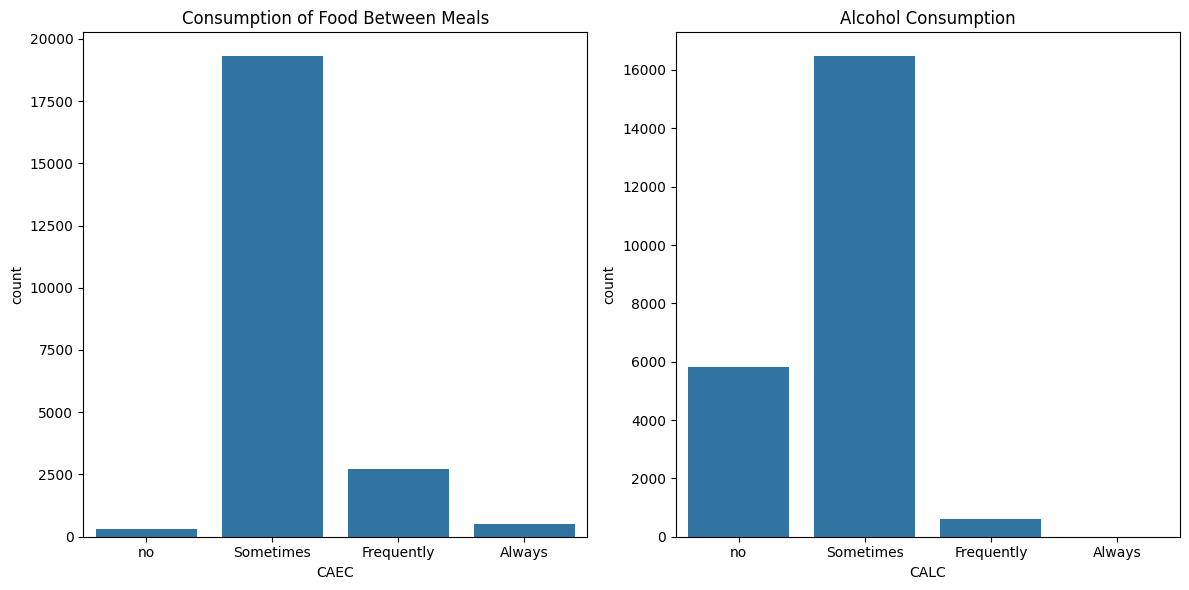

In [208]:
# Visualization of both distributions
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(data=training, x='CAEC', order = ["no", "Sometimes", "Frequently", "Always"])
plt.title('Consumption of Food Between Meals')
plt.subplot(1,2,2)
sns.countplot(data=training, x='CALC', order = ["no", "Sometimes", "Frequently", "Always"])
plt.title('Alcohol Consumption')
plt.tight_layout()
plt.show()

training['CAEC'] = training['CAEC'].replace({"no":0, "Sometimes":1, "Frequently":2, "Always":3})
# No instances of "Always" for Alcohol Consumption
training['CALC'] = training['CALC'].replace({"no":0, "Sometimes":1, "Frequently":2, "Always":3})

# One-Hot Encoding for Mode of Transportation and Gender
Since there isn't an apparent order for mode of transportation and gender, ordinal encoding should not be used.

In [209]:
# OneHotEncoder for Mode of Transportation
encoder = OneHotEncoder(sparse_output=False)
encodedMTRANS = encoder.fit_transform(training[['MTRANS']])
encodedMTRANSdf = pd.DataFrame(encodedMTRANS, columns=encoder.get_feature_names_out(["MTRANS"]))
# Fixing an issue with duplicated indices
training.reset_index(drop=True, inplace=True)
training = pd.concat([training, encodedMTRANSdf], axis=1)
training = training.rename(columns={"MTRANS_Automobile": "Automobile", "MTRANS_Bike": "Bike", "MTRANS_Motorbike": "Motorbike", "MTRANS_Public_Transportation": "Public Transport", "MTRANS_Walking": "Walk"})

# OneHotEncoder for Gender
encodedGender = encoder.fit_transform(training[['Gender']])
encodedGenderdf = pd.DataFrame(encodedGender, columns=encoder.get_feature_names_out(["Gender"]))
training.reset_index(drop=True, inplace=True)
training = pd.concat([training, encodedGenderdf], axis=1)
training = training.rename(columns={"Gender_Female":"Female", "Gender_Male":"Male"})
training = training.drop(columns=["Gender", "MTRANS"])
training.describe()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,...,CALC,NObeyesdad,BMI,Automobile,Bike,Motorbike,Public Transport,Walk,Female,Male
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,...,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,23.885263,1.700377,87.767610,0.819450,0.911627,2.443428,2.754344,1.150684,0.012637,2.027442,...,0.772574,3.245791,30.191840,0.174516,0.001705,0.002143,0.798767,0.022869,0.501334,0.498666
std,5.753419,0.087881,26.364243,0.384653,0.283843,0.533329,0.712711,0.450872,0.111705,0.608901,...,0.477871,2.056758,8.305989,0.379561,0.041262,0.046240,0.400931,0.149490,0.500009,0.500009
min,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,12.868541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.631662,66.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.000000,1.755907,...,0.000000,1.000000,24.092971,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,22.815416,1.700000,84.000000,1.000000,1.000000,2.392665,3.000000,1.000000,0.000000,2.000000,...,1.000000,3.000000,29.384757,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,26.000000,1.763029,111.531208,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.535127,...,1.000000,5.000000,36.878525,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,61.000000,1.980000,173.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,...,3.000000,6.000000,54.997991,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Cleaning Test Data

In [210]:
testData = pd.read_csv("/content/drive/My Drive/obesity test.csv")
testInput = testData.drop(columns=['id'])
# Convert categorical variables (Family History with Overweight, FAVC, Smoking) to numerical via ordinal encoding
testInput['family_history_with_overweight'] = testInput['family_history_with_overweight'].replace({"no":0, "yes":1})
testInput['FAVC'] = testInput['FAVC'].replace({"no":0, "yes":1})
testInput['SMOKE'] = testInput['SMOKE'].replace({"no":0, "yes":1})
testInput['SCC'] = testInput['SCC'].replace({"no":0, "yes":1})
# Calculating BMI
testInput['BMI'] = testInput['Weight']/(testInput['Height']**2)
# Ordinal Encoding for CAEC and CALC
testInput['CAEC'] = testInput['CAEC'].replace({"no":0, "Sometimes":1, "Frequently":2, "Always":3})
testInput['CALC'] = testInput['CALC'].replace({"no":0, "Sometimes":1, "Frequently":2, "Always":3})
# One-Hot Encoding for MTRANS and Gender
encodedMTRANS = encoder.fit_transform(testInput[['MTRANS']])
encodedMTRANSdf = pd.DataFrame(encodedMTRANS, columns=encoder.get_feature_names_out(["MTRANS"]))
testInput.reset_index(drop=True, inplace=True)
testInput = pd.concat([testInput, encodedMTRANSdf], axis=1)
testInput = testInput.rename(columns={"MTRANS_Automobile": "Automobile", "MTRANS_Bike": "Bike", "MTRANS_Motorbike": "Motorbike", "MTRANS_Public_Transportation": "Public Transport", "MTRANS_Walking": "Walk"})
encodedGender = encoder.fit_transform(testInput[['Gender']])
encodedGenderdf = pd.DataFrame(encodedGender, columns=encoder.get_feature_names_out(["Gender"]))
testInput.reset_index(drop=True, inplace=True)
testInput = pd.concat([testInput, encodedGenderdf], axis=1)
testInput = testInput.rename(columns={"Gender_Female":"Female", "Gender_Male":"Male"})
testInput = testInput.drop(columns=["Gender", "MTRANS"])

testInput.describe()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,...,TUE,CALC,BMI,Automobile,Bike,Motorbike,Public Transport,Walk,Female,Male
count,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,...,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000
mean,23.952740,1.698934,87.384504,0.822543,0.909176,2.442898,2.750610,1.156069,0.013006,2.032044,...,0.611033,0.771460,30.122959,0.173772,0.001806,0.001373,0.802818,0.020231,0.503251,0.496749
std,5.799814,0.088761,26.111819,0.382068,0.287369,0.531606,0.710927,0.457050,0.113303,0.611230,...,0.608005,0.476648,8.273030,0.378927,0.042464,0.037028,0.397885,0.140795,0.500007,0.500007
min,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,12.812830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.631662,65.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.000000,1.771781,...,0.000000,0.000000,23.875115,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,22.906342,1.700000,83.952968,1.000000,1.000000,2.358087,3.000000,1.000000,0.000000,2.000000,...,0.552498,1.000000,29.384757,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,26.000000,1.760710,111.157811,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.552388,...,1.000000,1.000000,36.727290,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,61.000000,1.980000,165.057269,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,...,2.000000,3.000000,51.227736,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Running Model on Test Data

In [211]:
# Attempted Hyperparameters along with public score:
# n_estimators: 100, max_depth: 3, learning_rate: 0.10 --> 0.89920
# n_estimators: 250, max_depth: 3, learning_rate: 0.10 --> 0.90679
# n_estimators: 400, max_depth: 3, learning_rate: 0.10 --> 0.90534
# Chose 250 as number of estimators

# n_estimators: 250, max_depth: 5, learning_rate: 0.10 --> 0.90643
# Chose max_depth as 3

# n_estimators: 250, max_depth: 3, learning_rate: 0.15 --> 0.90679
# Chose the following hyperparameters based on this testing:
model = GradientBoostingClassifier(n_estimators = 250, max_depth = 3, learning_rate = 0.15)
input = training.drop(columns=["NObeyesdad"])
output = training["NObeyesdad"]
model.fit(input, output)

prediction_data = pd.DataFrame(testInput, columns=input.columns)
predictions = model.predict(prediction_data)
predictions_df = pd.DataFrame(predictions, columns=["NObeyesdad"])
predictions_df["id"] = testData['id']
predictions_df = predictions_df[['id', 'NObeyesdad']]
flippedObesityMap = {v: k for k, v in obesityDictionary.items()}
predictions_df['NObeyesdad'] = predictions_df['NObeyesdad'].replace(flippedObesityMap)
predictions_df.to_csv('/content/drive/My Drive/obesity predictions.csv', index=False)